In [1]:
import time
import matplotlib.pyplot as plt

In this notebook, we use vectorisation to leverage our computer architecture in order to speed up computation.

The example used in this notebook is in the context of diffusion in fluids. More specifically, we are analysing the dynamics of how dye mixes with water if we put several drops in water at room temperature and without stirring the water. 

# Lists implementation

In [2]:
grid_shape = (1024, 1024)

def evolve(grid, dt, D = 1.0):
    '''
    Calculates the next state from the current state. 
    
    Parameters:
       - grid: current state
       - dt: time steps
       - D: dye's diffusion speed
    '''
    xmax, ymax = grid_shape
    new_grid = [[0.0,] * ymax for x in range(xmax)]
    for i in range(xmax): # Python 3 does not have xrange
            for j in range(ymax):
                # Gradients. Boundary condition: wrap around. 
                grid_xx = grid[(i + 1) % xmax][j] + grid[(i - 1) % xmax][j] - 2.0 * grid[i][j]
                grid_yy = grid[i][(j + 1) % ymax] + grid[i][(j - 1) % ymax] - 2.0 * grid[i][j]
                new_grid[i][j] = grid[i][j] + D * (grid_xx + grid_yy) * dt
    return new_grid

In [3]:
# Initialisation code. This code only runs once, as opposed to the previous function, that
# runs multiple times. That's why we will only analyse the complexity of the evolve function
def run_experiment(num_iterations):
    # Setting up initial conditions
    xmax, ymax = grid_shape
    grid = [[0.0, ] * ymax for x in range(xmax)]
    
    block_low = int(grid_shape[0] * .4)
    block_high = int(grid_shape[0] * .5)
    for i in range(block_low, block_high): # Python 3 does not have xrange
        for j in range(block_low, block_high):
            grid[i][j] = 0.005
            
    # Evolve the initial conditions
    start = time.time()
    for i in range(num_iterations):
        # The values in the grid and for dt have been chosen small enough so that
        # the algorithm will converge in a stable way
        grid = evolve(grid, 0.11)
    print(time.time() - start)
    
    return grid

9.5367431640625e-07
340.81495785713196
670.0406649112701


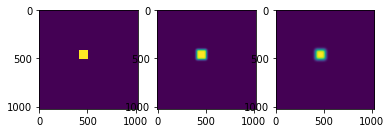

In [4]:
fig, ax = plt.subplots(1, 3)
for i in range(0,3):
    grid = run_experiment(i * 500)
    ax[i].imshow(grid)

## First quick optimisation

If we profile this code we will realise that most of the time is spent initialising `new_grid`. Allocating memory is expensive. Therefore. A first quick optimisation could be to take `new_grid` initialisation out from `evolve`, so it is initialised only once:

In [5]:
grid_shape = (1024, 1024)

def evolve(grid, dt, out, D = 1.0):
    '''
    Calculates the next state from the current state. 
    
    Parameters:
       - grid: current state
       - dt: time steps
       - D: dye's diffusion speed
    '''
    xmax, ymax = grid_shape
    for i in range(xmax): # Python 3 does not have xrange
            for j in range(ymax):
                # Gradients. Boundary condition: wrap around. 
                grid_xx = grid[(i + 1) % xmax][j] + grid[(i - 1) % xmax][j] - 2.0 * grid[i][j]
                grid_yy = grid[i][(j + 1) % ymax] + grid[i][(j - 1) % ymax] - 2.0 * grid[i][j]
                out[i][j] = grid[i][j] + D * (grid_xx + grid_yy) * dt

In [6]:
# Initialisation code. This code only runs once, as opposed to the previous function, that
# runs multiple times. That's why we will only analyse the complexity of the evolve function
def run_experiment(num_iterations):
    # Setting up initial conditions
    xmax, ymax = grid_shape
    next_grid = [[0.0,] * ymax for x in range(xmax)]
    grid = [[0.0, ] * ymax for x in range(xmax)]
    
    block_low = int(grid_shape[0] * .4)
    block_high = int(grid_shape[0] * .5)
    for i in range(block_low, block_high): # Python 3 does not have xrange
        for j in range(block_low, block_high):
            grid[i][j] = 0.005
            
    # Evolve the initial conditions
    start = time.time()
    for i in range(num_iterations):
        # The values in the grid and for dt have been chosen small enough so that
        # the algorithm will converge in a stable way
        evolve(grid, 0.11, next_grid)
        grid, next_grid = next_grid, grid
    print(time.time() - start)
    
    return grid

7.152557373046875e-07
340.083505153656
665.1243848800659


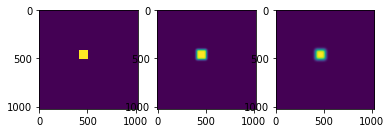

In [7]:
fig, ax = plt.subplots(1, 3)
for i in range(0,3):
    grid = run_experiment(i * 500)
    ax[i].imshow(grid)

There is some improvement, but not that much. We didn't get anything close to that 21% speed improvement demonstrated in the book. May it be because we are using Python 3?

However, another problem of lists is memory fragmentation. This means that accessing to list[i][j] requires two reading operations, and even if a set of elements are contiguous they cannot be accessed as a block, but one by one (using two operations for each).

But even if we use the `array` module we are not solving the problem, because in spite of arrays being able to store contiguous values in contiguous positions in memory, Python still doesn't know how to vectorise for loops (Python does not use vector operations in the CPU). Modules like `numpy` give us access to those vectorised operations (it also stores data in contiguous positions in memory - this last point has more impact on improving the performance than vectorisation). 

## Using numpy

This version of the code is written with `numpy`. It is based on the `roll` function, that requires allocating memory for a new array. But once that new array has been allocated, vectorisation pays off. 

In [17]:
import numpy as np

In [18]:
grid_shape = (1024, 1024)

In [19]:
def laplacian(grid):
    return np.roll(grid, +1, 0) + np.roll(grid, -1, 0) + \
           np.roll(grid, +1, 1) + np.roll(grid, -1, 1) - 4 * grid

In [20]:
def evolve(grid, dt, D = 1):
    return grid + dt * D * laplacian(grid)

In [27]:
def run_experiment(num_iterations):
    grid = np.zeros(grid_shape)
    
    block_low = int(grid_shape[0] * .4)
    block_high = int(grid_shape[0] * .5)
    grid[block_low:block_high, block_low:block_high] = 0.005
    
    start = time.time()
    for i in range(num_iterations):
        grid = evolve(grid, 0.1)
    print(time.time() - start)
    
    return grid

1.9073486328125e-06
6.207789897918701
12.784306049346924


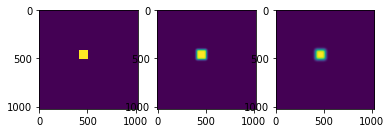

In [28]:
fig, ax = plt.subplots(1, 3)
for i in range(0,3):
    grid = run_experiment(i * 500)
    ax[i].imshow(grid)

By comparing these execution times with the previous ones we can see the more than obvious difference. 

This can be optimised further by removing the need for pre-allocating memory in the laplacian calculation. We can achieve that by using in-place operations like += and *=. 

In [33]:
def laplacian(grid, out):
    np.copyto(out, grid)
    out *= -4
    out += np.roll(grid, +1, 0)
    out += np.roll(grid, -1, 0)
    out += np.roll(grid, +1, 1)
    out += np.roll(grid, -1, 1)

In [34]:
def evolve(grid, dt, out, D = 1):
    laplacian(grid, out)
    out *= D * dt
    out += grid

In [35]:
def run_experiment(num_iterations):
    next_grid = np.zeros(grid_shape)
    grid = np.zeros(grid_shape)
    
    block_low = int(grid_shape[0] * .4)
    block_high = int(grid_shape[0] * .5)
    grid[block_low:block_high, block_low:block_high] = 0.005
    
    start = time.time()
    for i in range(num_iterations):
            evolve(grid, 0.1, next_grid)
            grid, next_grid = next_grid, grid
    print(time.time() - start)
    
    return grid

2.86102294921875e-06
5.3799707889556885
10.67466425895691


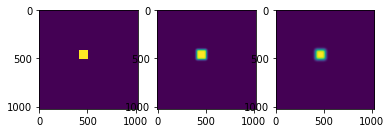

In [36]:
fig, ax = plt.subplots(1, 3)
for i in range(0,3):
    grid = run_experiment(i * 500)
    ax[i].imshow(grid)